# Introduction

Try to compare different algorithms on pure single cell results.
Both the 10x and C1 SmartSeq sections are using the 81,881 entry ENCODE4 bulk annotation set.

# Gene and Transcripts

Cell ranger and STAR Solo only produce Gene level count quantifications. When processing 10x data kallisto and salmon alevin produce gene counts as well.

When processing C1 data, Kallisto & Salmon only produce transcript quantifications, so for C1 gene level comparisons, transcript level quantifications are created by grouping all the transcripts by their gene id and summing those groups.

# Correlations Used

This notebook reuses the correlation method developed for the ENCODE3 Bulk RNA pipeline 

* Naive Spearman feeds all sample rows in raw data space to scipy's <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html">spearmanr</a> function
* Rafa Spearman is a filtered spearman correlation that requires both values to be expressed (non-zero) and the average expression between the two samples to be > 0 in $log_2$. (So at least > 1 in the raw data space)

My implementation <a href="https://github.com/detrout/long-rna-seq-condor/blob/master/woldrnaseq/madqc.py#L69">replicate_scores</a>.

Original R version <a href="https://github.com/ENCODE-DCC/long-rna-seq-pipeline/blob/master/dnanexus/mad-qc/resources/usr/bin/MAD.R">MAD.R</a>

In [1]:
import numpy
import scanpy
import anndata
import os
import pandas
from matplotlib import pyplot
from matplotlib import cm
import scipy
from pathlib import Path
import upsetplot
import louvain
import sklearn
import seaborn
import logging

from pipeline_common import get_gene_id_to_name, load_gtf
#from cuml.decomposition import PCA
#from cuml.manifold import TSNE


In [2]:
logger = logging.getLogger('notebook')

In [3]:
analysis_dir = Path('ENCSR874BOF_e10_5_limb')

In [4]:
scanpy.__version__

'1.4.5.1'

In [5]:
cellr_common = scanpy.read_h5ad(analysis_dir / 'cellranger_filtered.sparse.h5ad')
cellr_common

AnnData object with n_obs × n_vars = 6287 × 81881 
    var: 'gene_symbols', 'feature_types'

In [6]:
solo_common = scanpy.read_h5ad(analysis_dir / 'solo_filtered.sparse.h5ad')
solo_common

AnnData object with n_obs × n_vars = 6287 × 81881 
    var: 'gene_symbols'

In [7]:
alevin_common = scanpy.read_h5ad(analysis_dir / 'alevin_filtered.h5ad')
alevin_common

AnnData object with n_obs × n_vars = 6287 × 81881 
    var: 'gene_symbols'

In [8]:
kallisto_common = scanpy.read_h5ad(analysis_dir / 'kallisto_filtered.h5ad')
kallisto_common

AnnData object with n_obs × n_vars = 6287 × 81881 
    var: 'gene_symbols'

In [9]:
def replicate_scores(rep1, rep2, rep1_name, rep2_name, Acutoff=0):
    """Compute correlations, MAD, and SD replicate comparison scores

    Parameters
    ----------
    table: pandas.DataFrame
       DataFrame of RSEM quantifications
    rep1_name: str
       name of one column to score (library name)
    rep2_name: str
       name of the other column to score (library name)
    Acutoff: float
       Require that the average of the two replicates is greater
       than this cutoff in log2 space

    Returns
    -------
    pandas.Series
       Containing all the scores between the two replicates
    """
    #rep1 = table[rep1_name]
    #rep2 = table[rep2_name]

    eitherzero = (rep1 == 0) | (rep2 == 0)
    replz1 = numpy.log2(rep1[eitherzero != True])
    replz2 = numpy.log2(rep2[eitherzero != True])

    M = replz1 - replz2
    A = (replz1 + replz2) / 2.0
 
    replz1_gt_Acutoff = replz1[A > Acutoff]
    replz2_gt_Acutoff = replz2[A > Acutoff]

    skip_rafa = False
    if len(replz1_gt_Acutoff) < 100:
        #logger.warning("No data survived Acutoff filter in %s", rep1_name)
        skip_rafa = True
    if len(replz2_gt_Acutoff) < 100:
        #logger.warning("No data survived Acutoff filter in %s", rep2_name)
        skip_rafa = True

    if not skip_rafa:
        rafa_pearson = scipy.stats.pearsonr(replz1_gt_Acutoff,
                                            replz2_gt_Acutoff)[0]
        rafa_spearman= scipy.stats.spearmanr(replz1_gt_Acutoff,
                                             replz2_gt_Acutoff)[0]
    else:
        rafa_pearson = numpy.nan
        rafa_spearman = numpy.nan
    scores = pandas.Series({
        'total_rows': len(rep1),
        'passed_filter': len(replz1[A > Acutoff]),

        'naive_pearson': scipy.stats.pearsonr(rep1, rep2)[0],
        'naive_spearman': scipy.stats.spearmanr(rep1, rep2)[0],

        'rafa_pearson': rafa_pearson,
        'rafa_spearman': rafa_spearman,
        'MAD': numpy.round(numpy.median(numpy.abs(M)[A > Acutoff]) * 1.4826, 3),
        'SD': numpy.round(numpy.sqrt(numpy.mean(M[A > Acutoff] ** 2)), 3)
    },
        index=['total_rows', 'passed_filter',
               'naive_pearson', 'naive_spearman',
               'rafa_pearson', 'rafa_spearman',
               'MAD', 'SD']
    )
    return scores


In [10]:
dense_10x = {
    'cellranger': cellr_common.to_df().T,
    'solo': solo_common.to_df().T,
    'alevin': alevin_common.to_df().T,
    'kallisto': kallisto_common.to_df().T,
    #'kallisto EM': numpy.array(kallisto_em_common.X.todense()),
}

In [11]:
def compute_correlations(dense):
    programs = list(dense.keys())
    cell_correlations = {}

    for name_x in programs:
        for name_y in programs[programs.index(name_x):]:
            assert dense[name_x].shape == dense[name_y].shape
            for cell_id in dense[name_x].columns:
                cs_cors = replicate_scores(dense[name_x][cell_id], dense[name_y][cell_id], name_x, name_y)
                cell_correlations.setdefault(name_x, {}).setdefault(name_y, {})[cell_id] = cs_cors
    return cell_correlations

Just a warning... the all vs all comparison is slow.

In [12]:
tenx_correlations = compute_correlations(dense_10x)

In [13]:
len(tenx_correlations['cellranger']['solo'])

6287

In [14]:
def plot_cell_correlation_histogram(table, metric, title=None, bins=50):
    programs = list(table.keys())
    cell_hists = {}
    f = pyplot.figure(figsize=(7,7))
    if title is not None:
        f.suptitle(title.format(metric=metric))
    plot_size = len(programs)-1

    axes = f.subplots(plot_size, plot_size, sharex=True, sharey=True)
    for x, name_x in enumerate(programs):
        for y, name_y in enumerate(programs[programs.index(name_x)+1:]):
            #plot_index = plot_size * (y+x) + x + 1
            #ax = f.add_subplot(plot_size, plot_size, plot_index)
            ax = axes[y+x, x]
            if x == 0:
                ax.set_ylabel(name_y)

            spearman = []
            for cell_id in table[name_x][name_y]:
                spearman.append(table[name_x][name_y][cell_id][metric])
            #spearman = numpy.asarray(spearman)
            spearman = numpy.array(spearman)
            spearman = spearman[~numpy.isnan(spearman)]
            count = len(spearman)
            median = numpy.median(spearman)
            mean = numpy.mean(spearman)
            cell_hists.setdefault(name_x, {})[name_y] = ax.hist(spearman, bins=bins, density=True)
            ax.annotate(f'Mean {mean:0.2}\nMedian {median:0.2}\nCount {count}', xy=(0.1, 0.6), xycoords='axes fraction')
    for y in range(plot_size):
        axes[0, y].set_title(programs[y])
        axes[plot_size-1, y].set_xlabel(programs[y])
    #f.tight_layout()

In [15]:
def extract_score(correlations, metric, name_x, name_y):
    score = {}
    #name_x='cellranger'
    #name_y='kallisto'
    for cell_id in correlations[name_x][name_y]:
        score[cell_id] = correlations[name_x][name_y][cell_id][metric]
    return pandas.Series(score)    

In [16]:
def sc_scatter(table, correlations, metric, name_x, name_y, cell_id, ax=None):
    gridalpha = 0.5
    def is_spike(x):
        if x.startswith('gSpikein_') or x.startswith('tSpikein_'):
            return True
        else:
            return False

    if ax is None:
        f = pyplot.figure()
        ax = f.subplots(1,1)
    
    set1 = cm.get_cmap('Set1').colors
    colors = [{True: set1[0], False: set1[1]}[is_spike(x)] for x in table[name_x].index]

    ax.plot([-5,10], [-5,10], c=set1[2])
    ax.scatter(numpy.log2(table[name_x][cell_id]+0.01), numpy.log2(table[name_y][cell_id]+0.01), color=colors, s=2)
    rafa_spearman = correlations[name_x][name_y][cell_id][metric]
    passed_filter = correlations[name_x][name_y][cell_id]["passed_filter"]
    ax.set_title(f'id {cell_id}\n{metric} {rafa_spearman:0.4}\nCount {int(passed_filter)}')
    ax.set_xlabel(name_x)
    ax.set_ylabel(name_y)
    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)



In [17]:
def show_scatter_extremes(dense_mat, correlations, metric, name_x, name_y):
    scores = extract_score(correlations, metric, name_x, name_y)
    best_cell = scores.idxmax()
    worst_cell = scores.idxmin()
    # find smallest absolute difference from median and use that as median cell
    median = numpy.abs(scores - scores.median())
    median_cell = median.idxmin()
    
    f = pyplot.figure(figsize=(12,4))
    #f.suptitle(f'{metric} worst, median and best cells')
    axes = f.subplots(1,3, sharex=True, sharey=True)
    sc_scatter(dense_mat, correlations, metric, name_x, name_y, worst_cell, ax=axes[0])
    sc_scatter(dense_mat, correlations, metric, name_x, name_y, median_cell, ax=axes[1])
    sc_scatter(dense_mat, correlations, metric, name_x, name_y, best_cell, ax=axes[2])

# Scatter plot comparisons

I have several slides where I wanted to get a sense of how the different algorithms performed on a cell.

What I settled on is a panel of 3 scatter plots that show the cell with the lowest correlation, the median correlation, and the best correlation between two selected algorithms.

Data points are in blue, spike-in values are in red and the line y=x is in green.

For 10x data there were no spike ins added, so all the spikes should be at 0,0 for naive, or min_threshold = $log_2 0.01$. Once in a while there's a read spuriously maps to the spike ins and so there might be one non-zero spike in the 10x data.

# 10x e10.5 full annotation

These plots are derived from <a href="https://www.encodeproject.org/experiments/ENCSR874BOF/">ENCSR874BOF</a> our e10.5 mouse forelimb dataset. They were analyzed with indicies built from the full ENCODE Bulk RNA-seq GTF file. This is unusual, many other 10x comparisons are done with a much smaller set that focuses on protein coding, lincRNA and antisense genes as well as the TR and IG annotations. A quick inspection suggests processed transcripts and pseudogenes appear to be the largest categories removed. See <a href="http://woldlab.caltech.edu/~diane/encode-202006-jamboree-detrout-rna-sc-pipeline/compare-10x-vs-ENCODE-gtf.html">compare-10x-vs-ENCODE-gtf</a> for more details.

The 10x cells selected were the intersection of Cellranger, STAR Solo, and Alevin methods, which happens to be the cells selected by STAR Solo.

# 10x full annotation naive spearman count correlation histogram (50 bins)

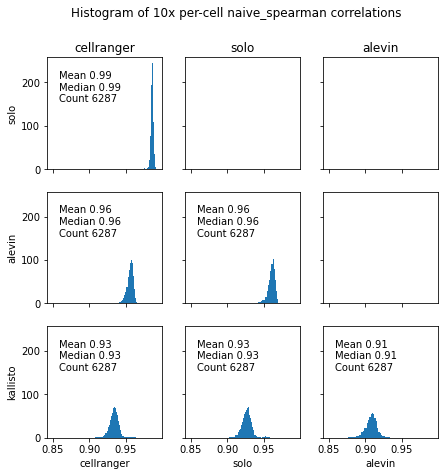

In [18]:
plot_cell_correlation_histogram(tenx_correlations, 'naive_spearman','Histogram of 10x per-cell {metric} correlations', bins=50)

# 10x full annotation worst, median, best naive spearman count cellranger vs star solo 

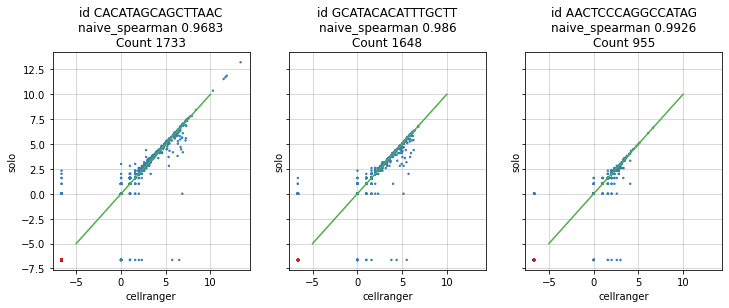

In [19]:
show_scatter_extremes(dense_10x, tenx_correlations, 'naive_spearman', 'cellranger', 'solo')

# 10x full annotation correlations naive spearman worst, median, best cellrange vs alevin

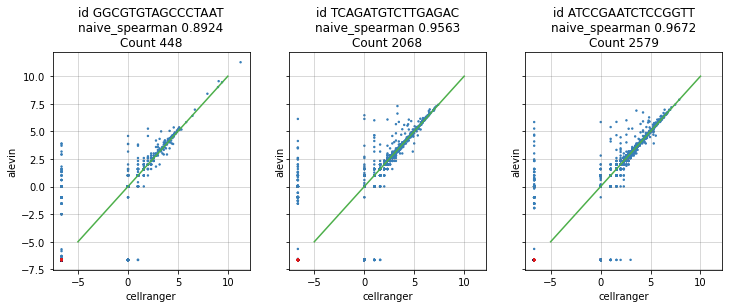

In [20]:
show_scatter_extremes(dense_10x, tenx_correlations, 'naive_spearman', 'cellranger', 'alevin')

# 10x both naive spearman worst, median, best cellranger vs kallisto

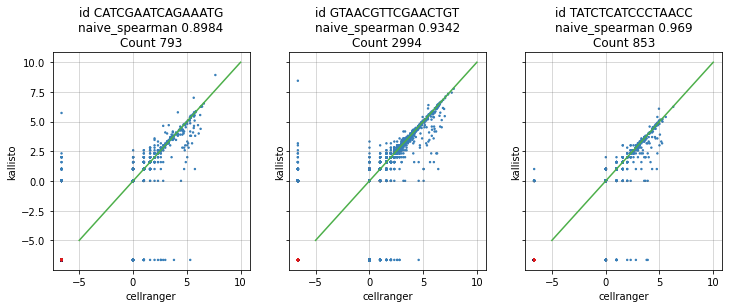

In [21]:
show_scatter_extremes(dense_10x, tenx_correlations, 'naive_spearman', 'cellranger', 'kallisto')

## 10x naive spearman solo vs alevin

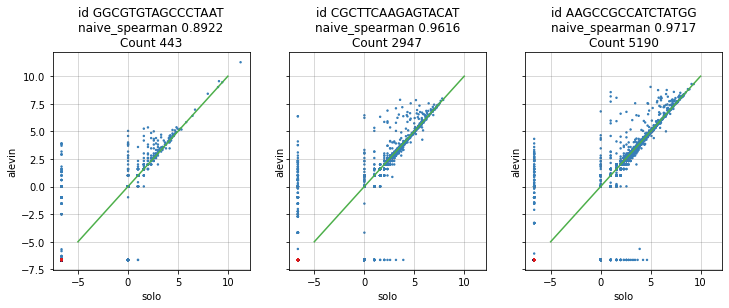

In [22]:
show_scatter_extremes(dense_10x, tenx_correlations, 'naive_spearman', 'solo', 'alevin')

## 10x spearman solo vs kallisto

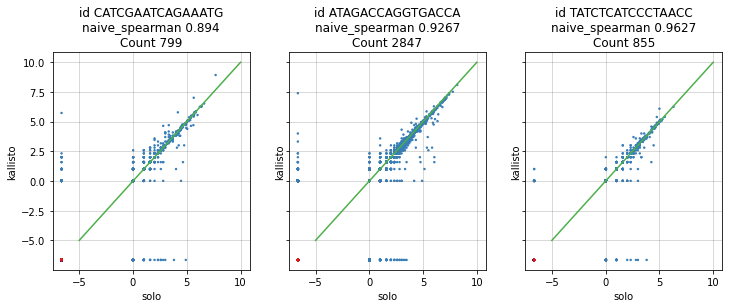

In [23]:
show_scatter_extremes(dense_10x, tenx_correlations, 'naive_spearman', 'solo', 'kallisto')

## 10x spearman alevin vs kallisto

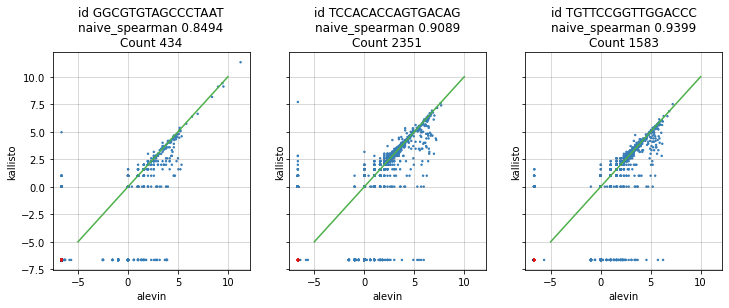

In [24]:
show_scatter_extremes(dense_10x, tenx_correlations, 'naive_spearman', 'alevin', 'kallisto')

# 10x rafa filtered count correlation histogram

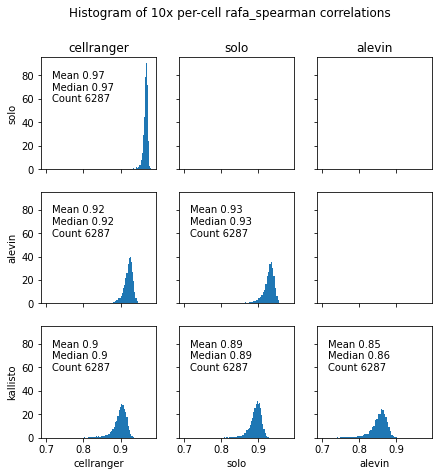

In [25]:
plot_cell_correlation_histogram(tenx_correlations, 'rafa_spearman','Histogram of 10x per-cell {metric} correlations', bins=50)

# 10x counts worst, median, best rafa spearman cellranger vs solo

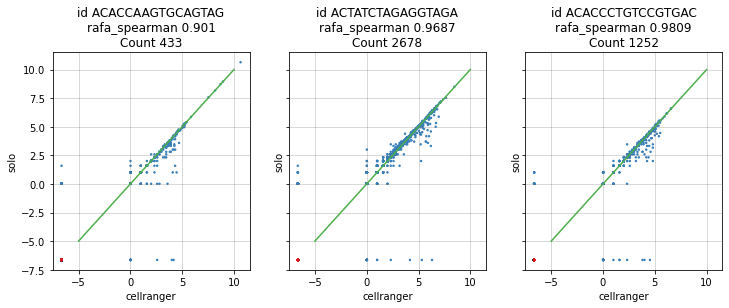

In [26]:
show_scatter_extremes(dense_10x, tenx_correlations, 'rafa_spearman', 'cellranger', 'solo')

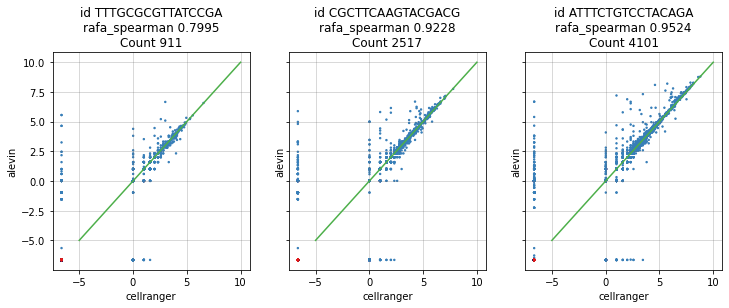

In [27]:
show_scatter_extremes(dense_10x, tenx_correlations, 'rafa_spearman', 'cellranger', 'alevin')

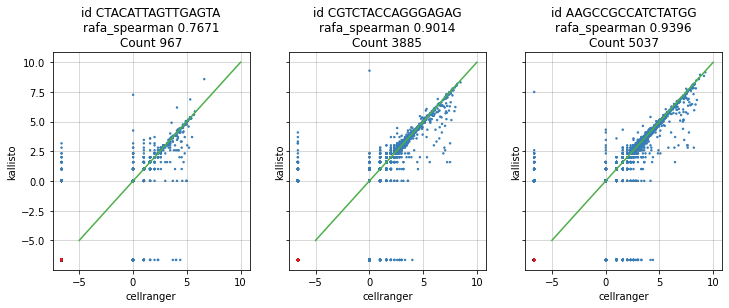

In [28]:
show_scatter_extremes(dense_10x, tenx_correlations, 'rafa_spearman', 'cellranger', 'kallisto')

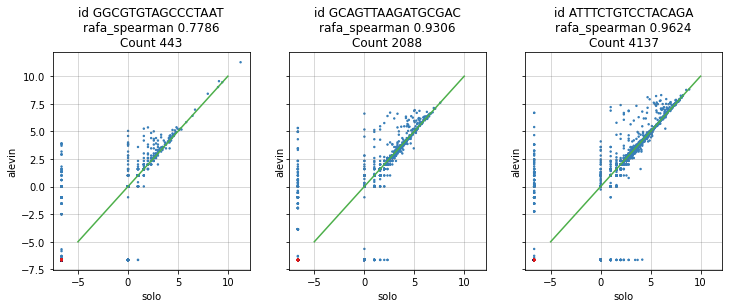

In [29]:
show_scatter_extremes(dense_10x, tenx_correlations, 'rafa_spearman', 'solo', 'alevin')

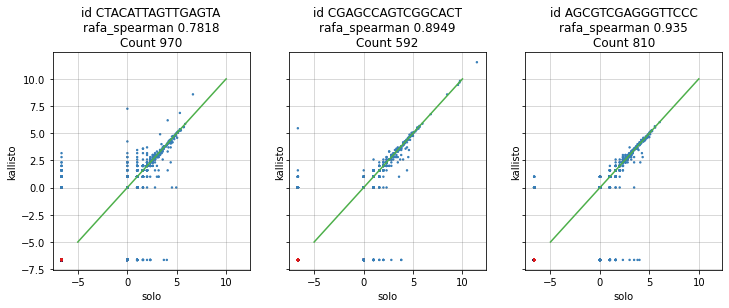

In [30]:
show_scatter_extremes(dense_10x, tenx_correlations, 'rafa_spearman', 'solo', 'kallisto')

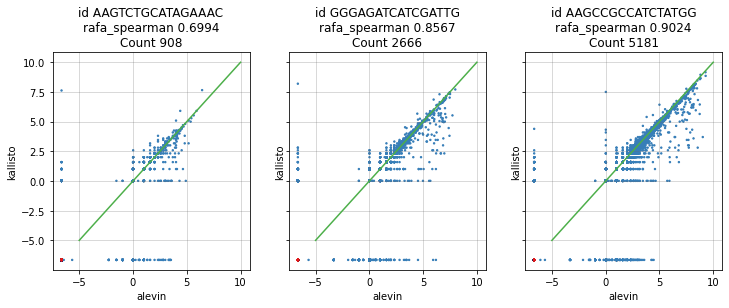

In [31]:
show_scatter_extremes(dense_10x, tenx_correlations, 'rafa_spearman', 'alevin', 'kallisto')

# C1 processed cells

In [32]:
suffix = '_gene_counts.h5ad'
c1_gene_counts = {}
for filename in sorted(Path('c1_pseudo/').glob('*'+suffix)):
    name = filename.name[:-len(suffix)]
    h5ad = scanpy.read_h5ad(filename)
    c1_gene_counts[name] = h5ad.to_df().T
    print(name, c1_gene_counts[name].shape)


kallisto (81881, 845)
rsem (81881, 845)
salmon_decoy (81881, 845)
salmon (81881, 845)
star (81881, 845)


In [33]:
c1_gene_count_correlations = compute_correlations(c1_gene_counts)

# C1 naive spearman gene count histogram

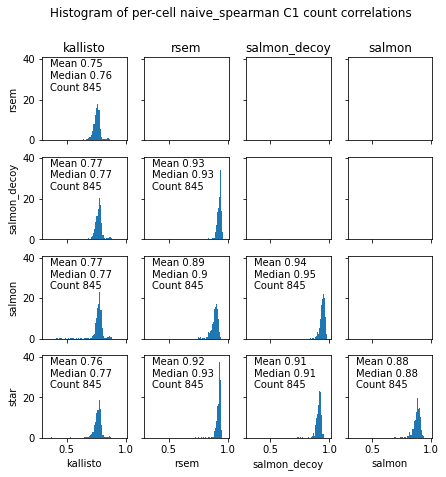

In [34]:
plot_cell_correlation_histogram(c1_gene_count_correlations, 'naive_spearman','Histogram of per-cell {metric} C1 count correlations')

# C1 gene counts worst, median, best both naive spearman kallisto vs rsem

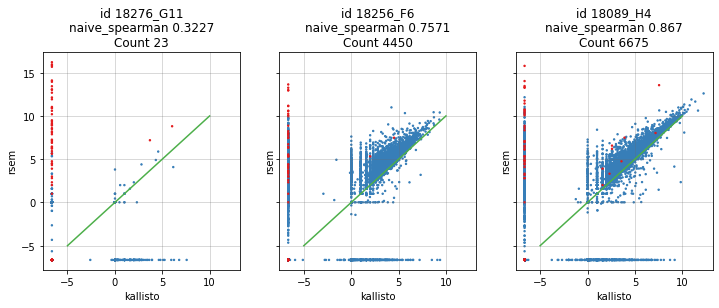

In [35]:
show_scatter_extremes(c1_gene_counts, c1_gene_count_correlations, 'naive_spearman', 'kallisto', 'rsem')

# C1 gene counts worst, median, best both non-zero kallisto vs salmon

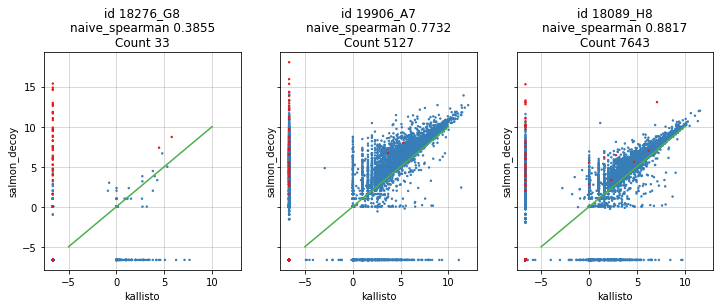

In [36]:
show_scatter_extremes(c1_gene_counts, c1_gene_count_correlations, 'naive_spearman', 'kallisto', 'salmon_decoy')

## C1 gene counts spearman kallisto vs salmon

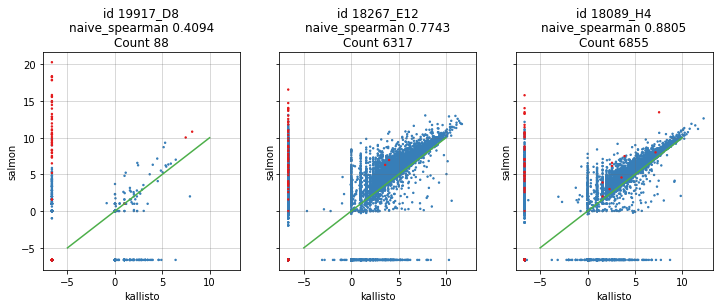

In [37]:
show_scatter_extremes(c1_gene_counts, c1_gene_count_correlations, 'naive_spearman', 'kallisto', 'salmon')

## C1 gene counts spearman kallisto vs star

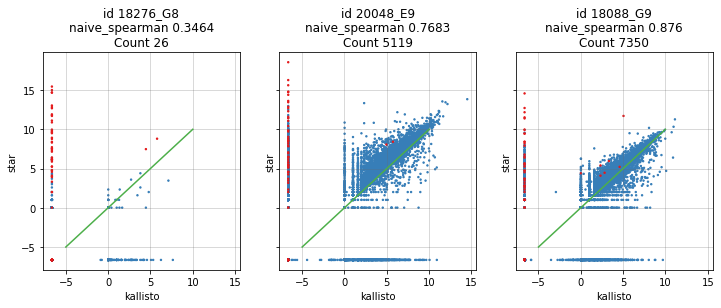

In [38]:
show_scatter_extremes(c1_gene_counts, c1_gene_count_correlations, 'naive_spearman', 'kallisto', 'star')

## C1 gene counts rsem vs salmon decoy

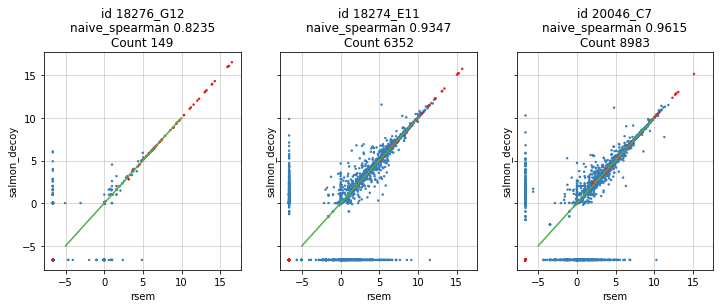

In [39]:
show_scatter_extremes(c1_gene_counts, c1_gene_count_correlations, 'naive_spearman', 'rsem', 'salmon_decoy')

## C1 gene counts rsem vs salmon

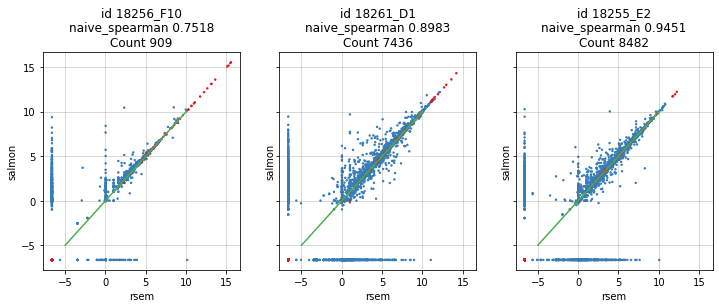

In [40]:
show_scatter_extremes(c1_gene_counts, c1_gene_count_correlations, 'naive_spearman', 'rsem', 'salmon')

## C1 gene counts spearman rsem vs star

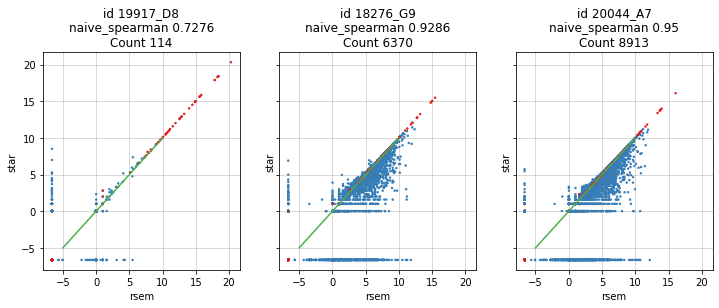

In [41]:
show_scatter_extremes(c1_gene_counts, c1_gene_count_correlations, 'naive_spearman', 'rsem', 'star')

## C1 gene counts spearman salmon_decoy vs salmon

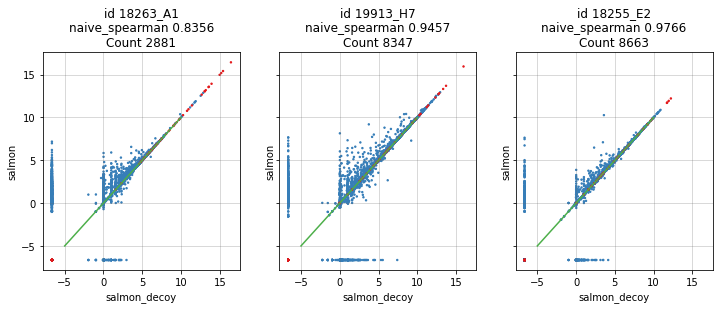

In [42]:
show_scatter_extremes(c1_gene_counts, c1_gene_count_correlations, 'naive_spearman', 'salmon_decoy', 'salmon')

## C1 gene counts salmon decoy vs star

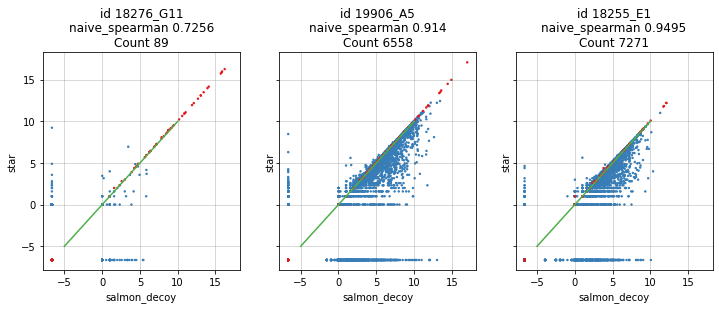

In [43]:
show_scatter_extremes(c1_gene_counts, c1_gene_count_correlations, 'naive_spearman', 'salmon_decoy', 'star')

## C1 gene counts salmon vs star

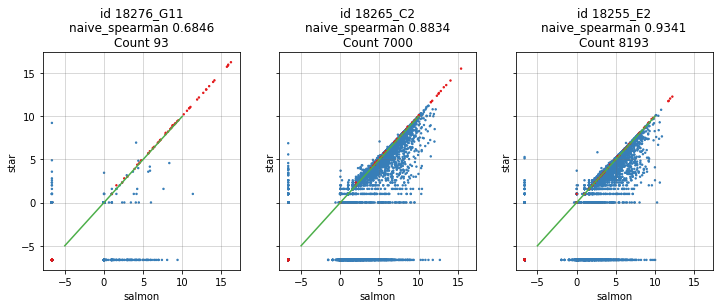

In [44]:
show_scatter_extremes(c1_gene_counts, c1_gene_count_correlations, 'naive_spearman', 'salmon', 'star')

# C1 gene counts rafa spearman histogram 

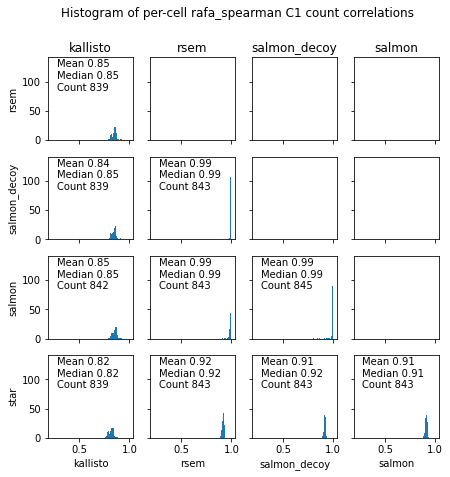

In [45]:
plot_cell_correlation_histogram(c1_gene_count_correlations, 'rafa_spearman','Histogram of per-cell {metric} C1 count correlations')

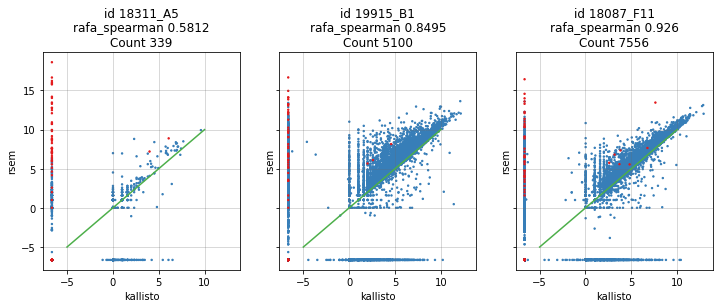

In [46]:
show_scatter_extremes(c1_gene_counts, c1_gene_count_correlations, 'rafa_spearman', 'kallisto', 'rsem')

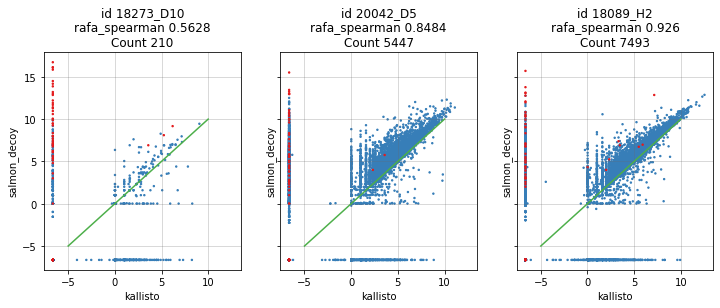

In [47]:
show_scatter_extremes(c1_gene_counts, c1_gene_count_correlations, 'rafa_spearman', 'kallisto', 'salmon_decoy')

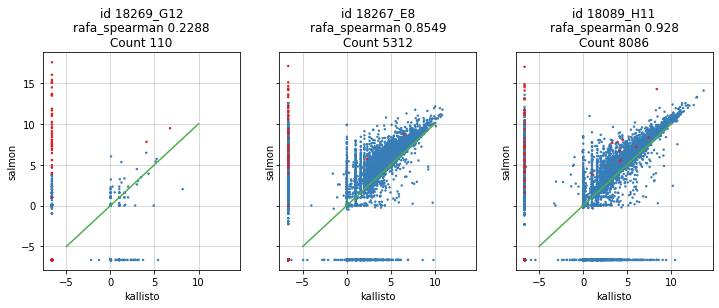

In [48]:
show_scatter_extremes(c1_gene_counts, c1_gene_count_correlations, 'rafa_spearman', 'kallisto', 'salmon')

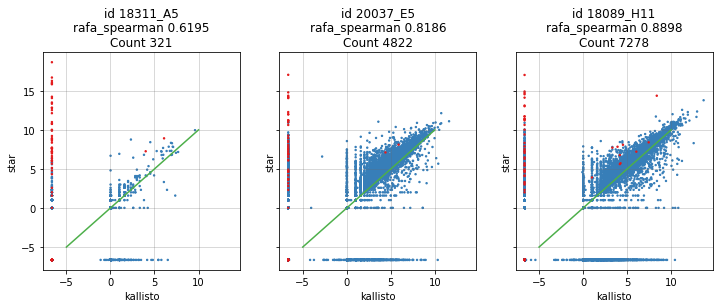

In [49]:
show_scatter_extremes(c1_gene_counts, c1_gene_count_correlations, 'rafa_spearman', 'kallisto', 'star')

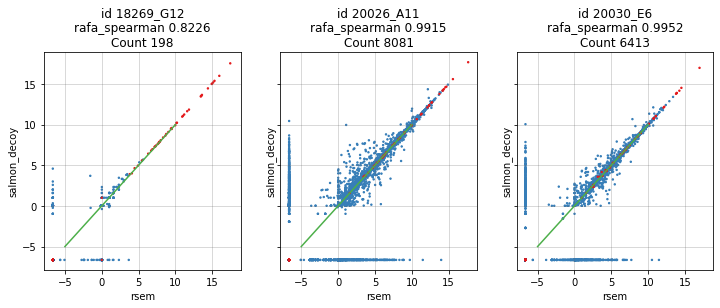

In [50]:
show_scatter_extremes(c1_gene_counts, c1_gene_count_correlations, 'rafa_spearman', 'rsem', 'salmon_decoy')

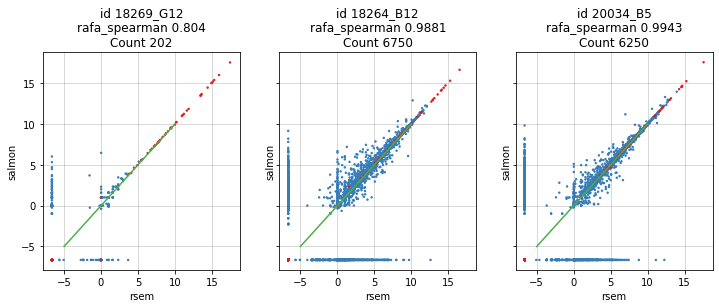

In [51]:
show_scatter_extremes(c1_gene_counts, c1_gene_count_correlations, 'rafa_spearman', 'rsem', 'salmon')

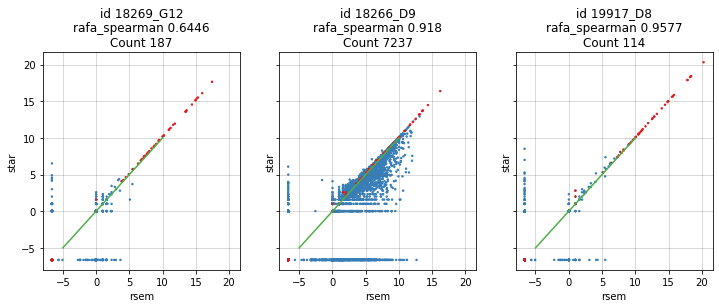

In [52]:
show_scatter_extremes(c1_gene_counts, c1_gene_count_correlations, 'rafa_spearman', 'rsem', 'star')

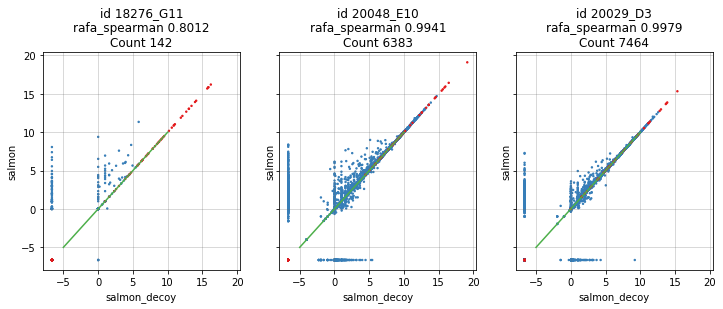

In [53]:
show_scatter_extremes(c1_gene_counts, c1_gene_count_correlations, 'rafa_spearman', 'salmon_decoy', 'salmon')

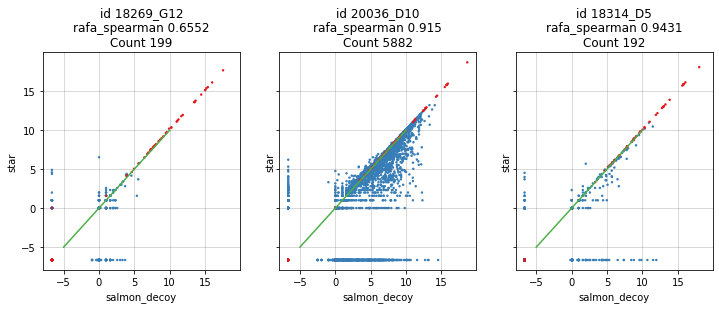

In [54]:
show_scatter_extremes(c1_gene_counts, c1_gene_count_correlations, 'rafa_spearman', 'salmon_decoy', 'star')

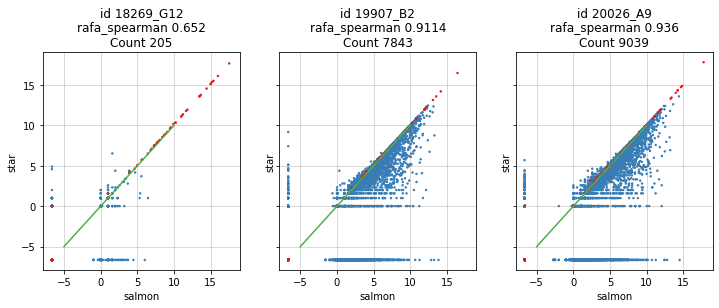

In [55]:
show_scatter_extremes(c1_gene_counts, c1_gene_count_correlations, 'rafa_spearman', 'salmon', 'star')

# C1 Gene TPMs

In [56]:
suffix = '_gene_tpms.h5ad'
c1_gene_tpms = {}
for filename in sorted(Path('c1_pseudo/').glob('*'+suffix)):
    name = filename.name[:-len(suffix)]
    h5ad = scanpy.read_h5ad(filename)
    c1_gene_tpms[name] = h5ad.to_df().T
    print(name, c1_gene_tpms[name].shape)


kallisto (81881, 845)
rsem (81881, 845)
salmon_decoy (81881, 845)
salmon (81881, 845)


In [57]:
c1_gene_tpm_correlations = compute_correlations(c1_gene_tpms)

# Histogram C1 naive spearman gene TPMs 

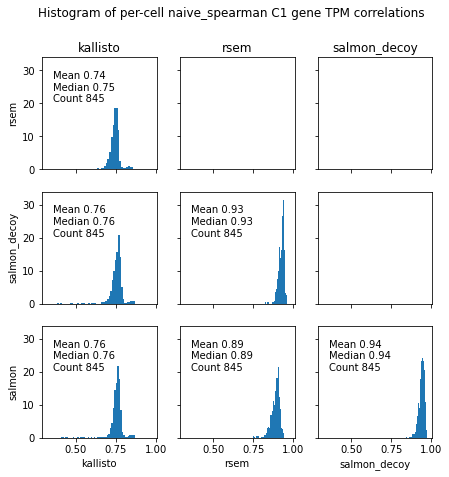

In [58]:
plot_cell_correlation_histogram(c1_gene_tpm_correlations, 'naive_spearman','Histogram of per-cell {metric} C1 gene TPM correlations', bins=50)

# C1 gene TPMs best, median, worst both non-zero kallisto vs rsem

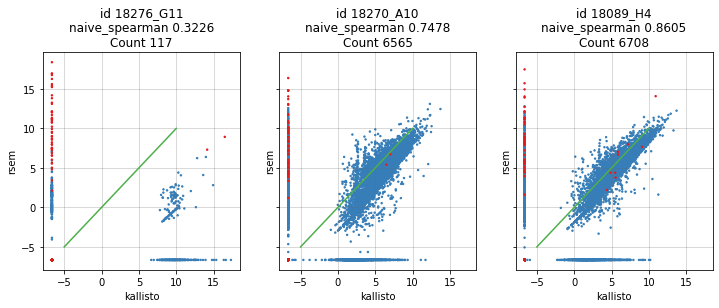

In [59]:
show_scatter_extremes(c1_gene_tpms, c1_gene_tpm_correlations, 'naive_spearman', 'kallisto', 'rsem')

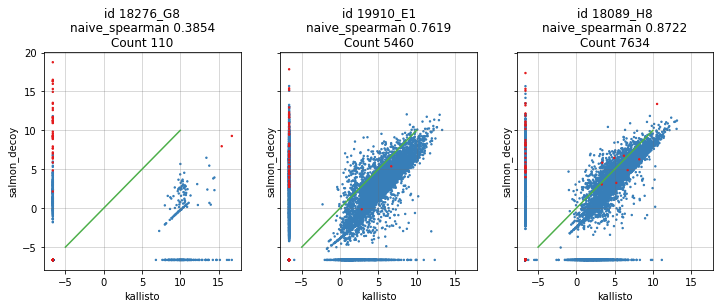

In [60]:
show_scatter_extremes(c1_gene_tpms, c1_gene_tpm_correlations, 'naive_spearman', 'kallisto', 'salmon_decoy')

# C1 gene TPMs best, median, worst naive spearman kallisto vs salmon

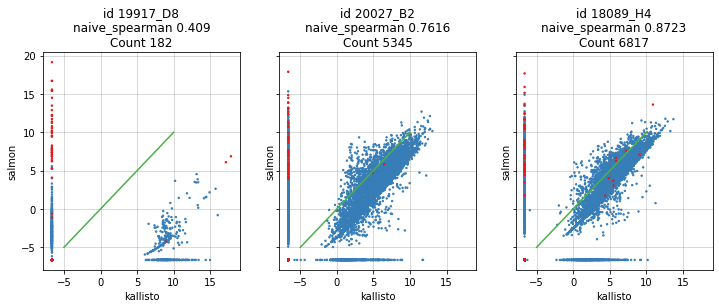

In [61]:
show_scatter_extremes(c1_gene_tpms, c1_gene_tpm_correlations, 'naive_spearman', 'kallisto', 'salmon')

# C1 gene TPMs best, median, worst naive spearman rsem vs rsem

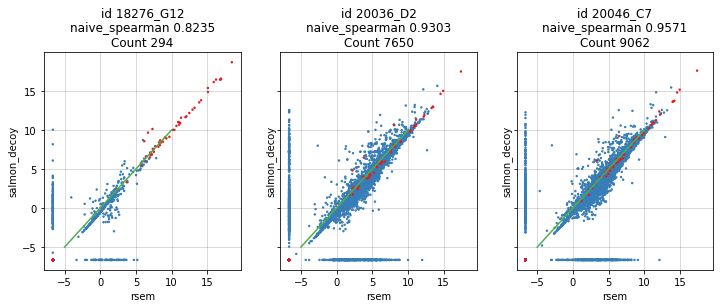

In [62]:
show_scatter_extremes(c1_gene_tpms, c1_gene_tpm_correlations, 'naive_spearman', 'rsem', 'salmon_decoy')

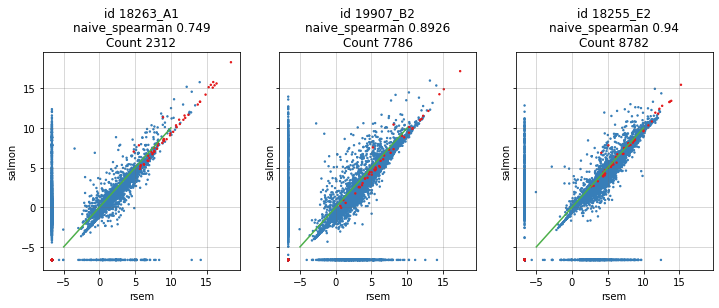

In [63]:
show_scatter_extremes(c1_gene_tpms, c1_gene_tpm_correlations, 'naive_spearman', 'rsem', 'salmon')

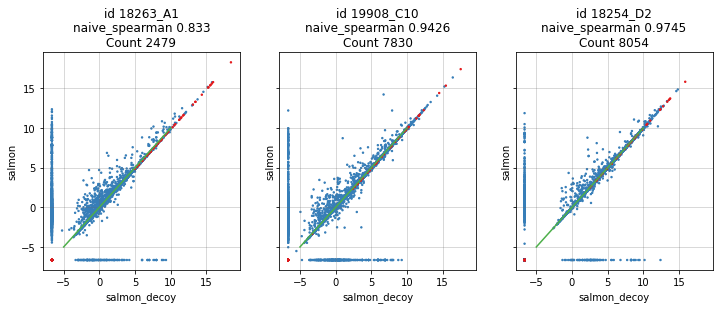

In [64]:
show_scatter_extremes(c1_gene_tpms, c1_gene_tpm_correlations, 'naive_spearman', 'salmon_decoy', 'salmon')

# C1 gene TPM rafa spearman histogram

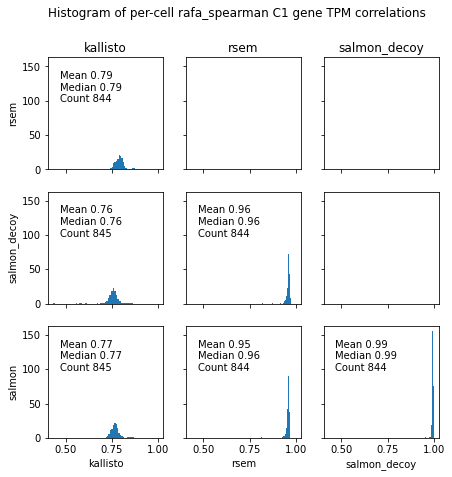

In [65]:
plot_cell_correlation_histogram(c1_gene_tpm_correlations, 'rafa_spearman','Histogram of per-cell {metric} C1 gene TPM correlations', bins=50)

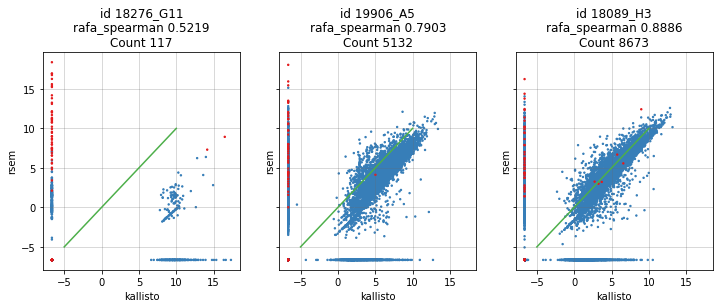

In [66]:
show_scatter_extremes(c1_gene_tpms, c1_gene_tpm_correlations, 'rafa_spearman', 'kallisto', 'rsem')

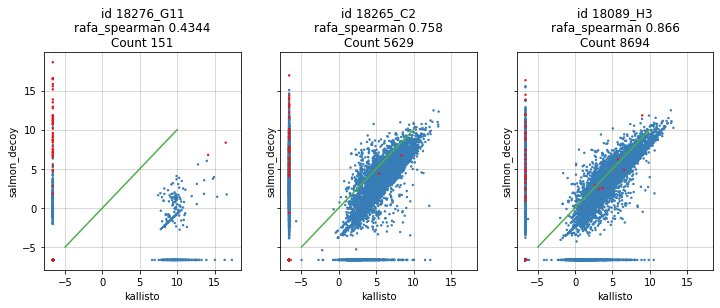

In [67]:
show_scatter_extremes(c1_gene_tpms, c1_gene_tpm_correlations, 'rafa_spearman', 'kallisto', 'salmon_decoy')

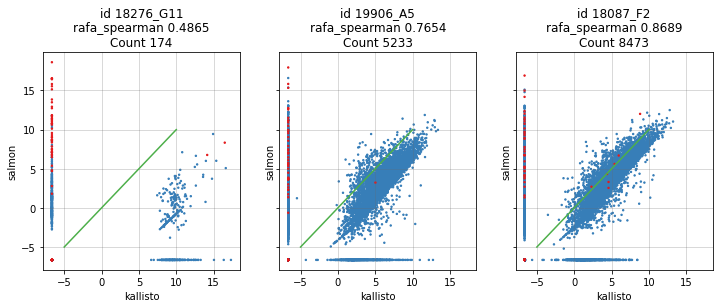

In [68]:
show_scatter_extremes(c1_gene_tpms, c1_gene_tpm_correlations, 'rafa_spearman', 'kallisto', 'salmon')

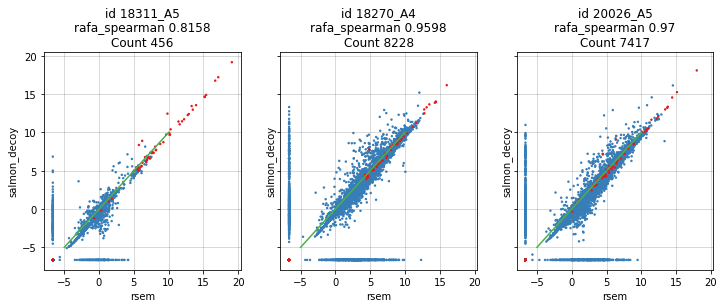

In [69]:
show_scatter_extremes(c1_gene_tpms, c1_gene_tpm_correlations, 'rafa_spearman', 'rsem', 'salmon_decoy')

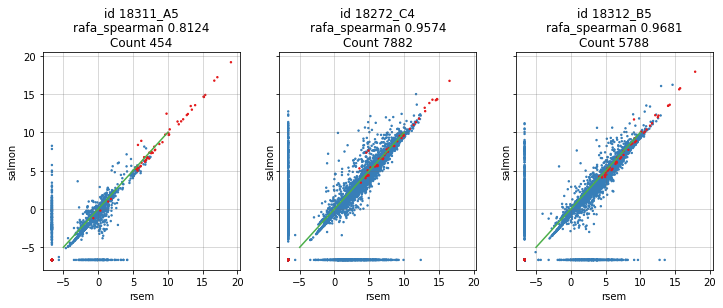

In [70]:
show_scatter_extremes(c1_gene_tpms, c1_gene_tpm_correlations, 'rafa_spearman', 'rsem', 'salmon')

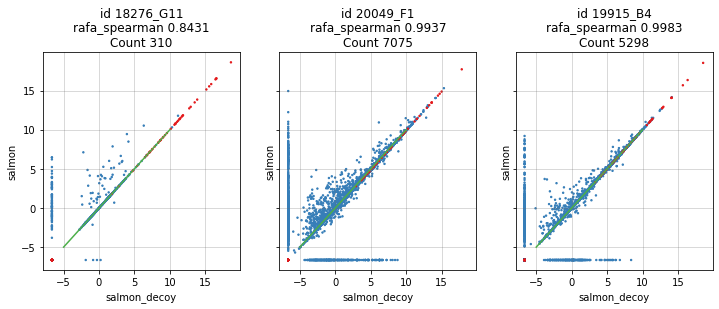

In [71]:
show_scatter_extremes(c1_gene_tpms, c1_gene_tpm_correlations, 'rafa_spearman', 'salmon_decoy', 'salmon')

# C1 transcript count naive spearman correlation histogram

In [72]:
suffix = '_transcript_counts.h5ad'
c1_transcript_counts = {}
for filename in sorted(Path('c1_pseudo/').glob('*'+suffix)):
    name = filename.name[:-len(suffix)]
    h5ad = scanpy.read_h5ad(filename)
    c1_transcript_counts[name] = h5ad.to_df().T
    print(name, c1_transcript_counts[name].shape)


kallisto (168207, 845)
rsem (168207, 845)
salmon_decoy (168207, 845)
salmon (168207, 845)


In [73]:
c1_transcript_count_correlations = compute_correlations(c1_transcript_counts)

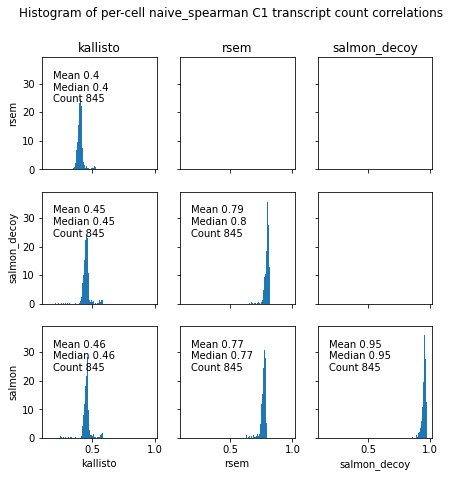

In [74]:
plot_cell_correlation_histogram(c1_transcript_count_correlations, 'naive_spearman','Histogram of per-cell {metric} C1 transcript count correlations', bins=50)

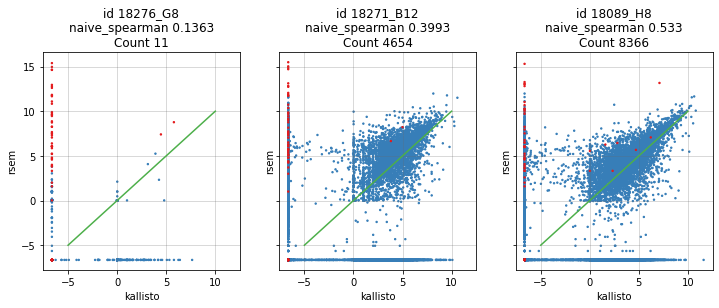

In [75]:
show_scatter_extremes(c1_transcript_counts, c1_transcript_count_correlations, 'naive_spearman', 'kallisto', 'rsem')

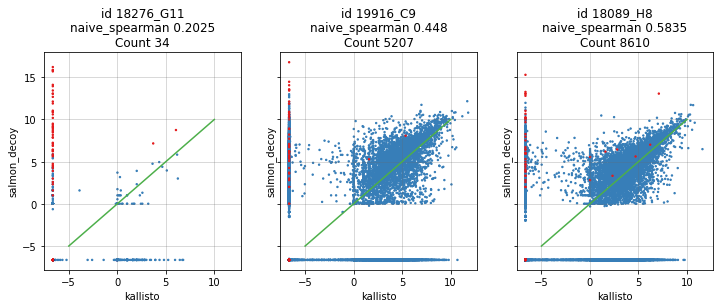

In [76]:
show_scatter_extremes(c1_transcript_counts, c1_transcript_count_correlations, 'naive_spearman', 'kallisto', 'salmon_decoy')

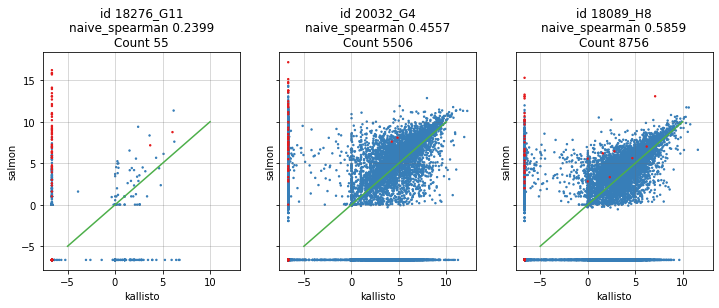

In [77]:
show_scatter_extremes(c1_transcript_counts, c1_transcript_count_correlations, 'naive_spearman', 'kallisto', 'salmon')

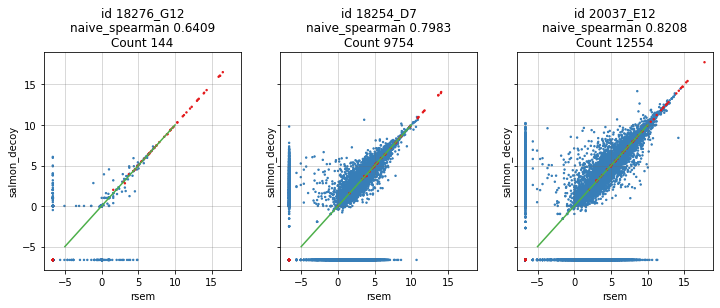

In [78]:
show_scatter_extremes(c1_transcript_counts, c1_transcript_count_correlations, 'naive_spearman', 'rsem', 'salmon_decoy')

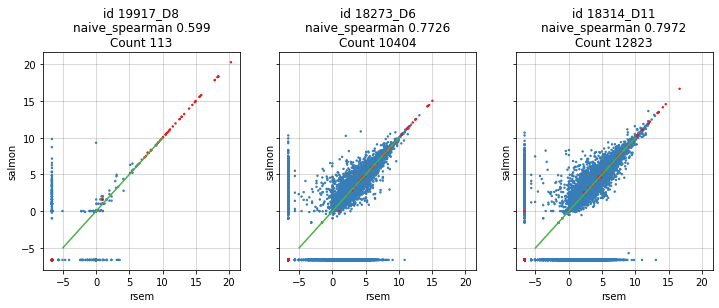

In [79]:
show_scatter_extremes(c1_transcript_counts, c1_transcript_count_correlations, 'naive_spearman', 'rsem', 'salmon')

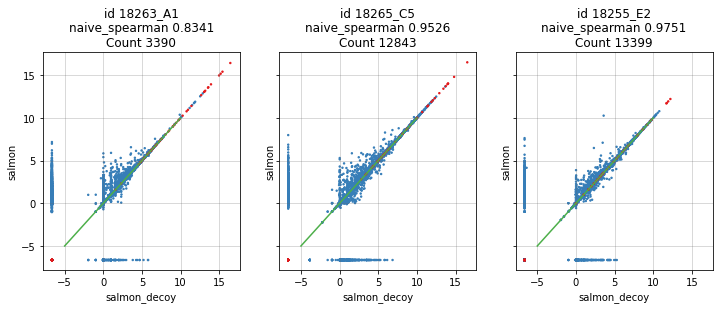

In [80]:
show_scatter_extremes(c1_transcript_counts, c1_transcript_count_correlations, 'naive_spearman', 'salmon_decoy', 'salmon')

# C1 transcript count rafa spearman correlation histogram

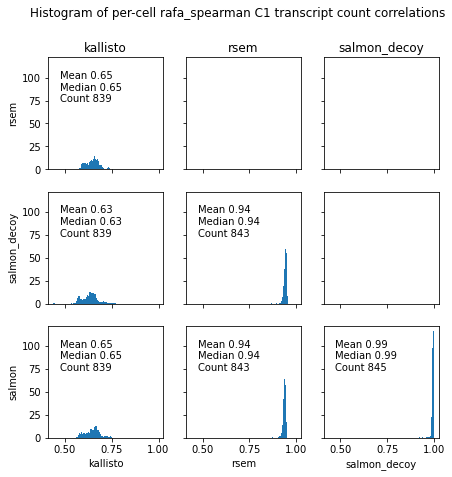

In [81]:
plot_cell_correlation_histogram(c1_transcript_count_correlations, 'rafa_spearman','Histogram of per-cell {metric} C1 transcript count correlations', bins=50)

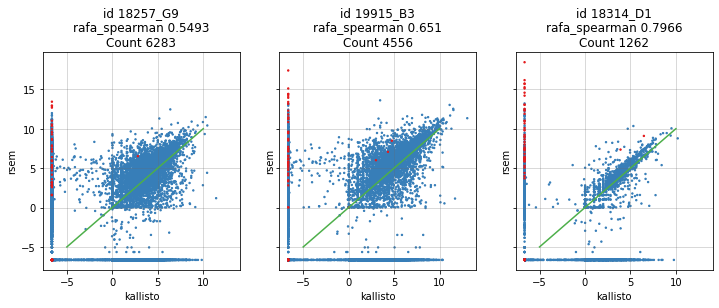

In [82]:
show_scatter_extremes(c1_transcript_counts, c1_transcript_count_correlations, 'rafa_spearman', 'kallisto', 'rsem')

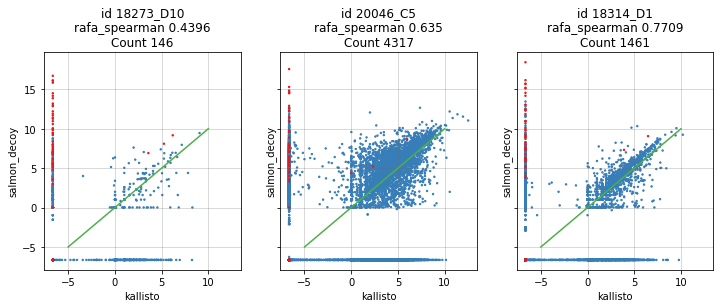

In [83]:
show_scatter_extremes(c1_transcript_counts, c1_transcript_count_correlations, 'rafa_spearman', 'kallisto', 'salmon_decoy')

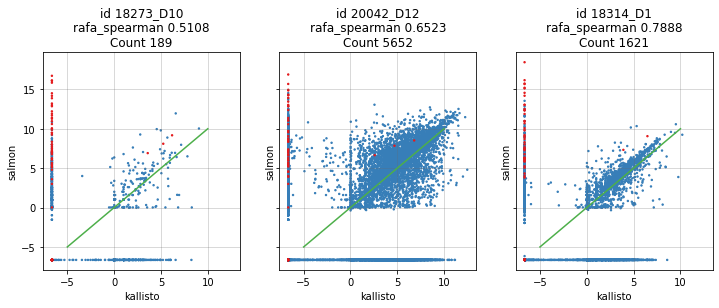

In [84]:
show_scatter_extremes(c1_transcript_counts, c1_transcript_count_correlations, 'rafa_spearman', 'kallisto', 'salmon')

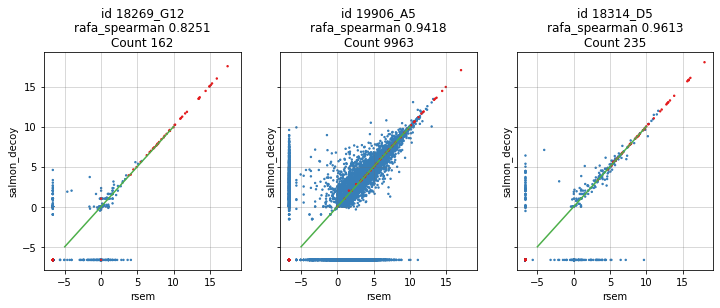

In [85]:
show_scatter_extremes(c1_transcript_counts, c1_transcript_count_correlations, 'rafa_spearman', 'rsem', 'salmon_decoy')

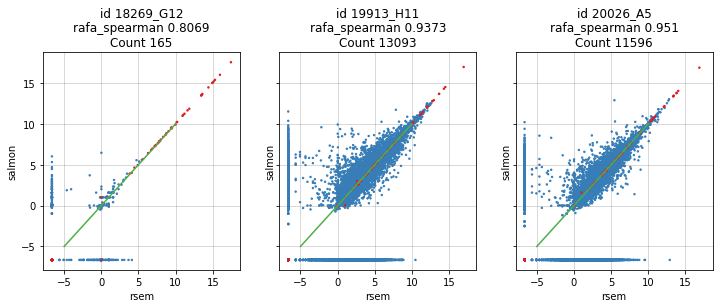

In [86]:
show_scatter_extremes(c1_transcript_counts, c1_transcript_count_correlations, 'rafa_spearman', 'rsem', 'salmon')

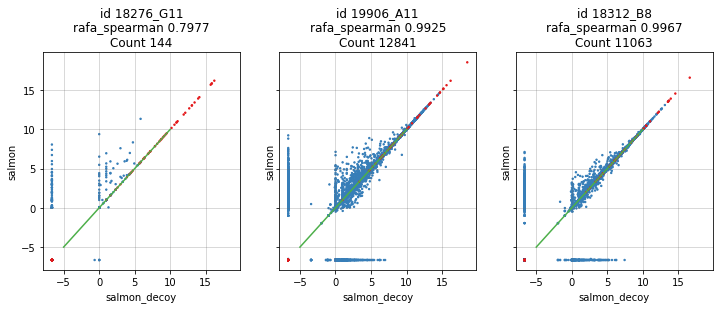

In [87]:
show_scatter_extremes(c1_transcript_counts, c1_transcript_count_correlations, 'rafa_spearman', 'salmon_decoy', 'salmon')

# C1 transcript TPM naive spearman correlation histogram

In [88]:
suffix = '_transcript_tpms.h5ad'
c1_transcript_tpms = {}
for filename in sorted(Path('c1_pseudo/').glob('*'+suffix)):
    name = filename.name[:-len(suffix)]
    h5ad = scanpy.read_h5ad(filename)
    c1_transcript_tpms[name] = h5ad.to_df().T
    print(name, c1_transcript_tpms[name].shape)


kallisto (168207, 845)
rsem (168207, 845)
salmon_decoy (168207, 845)
salmon (168207, 845)


In [89]:
c1_transcript_tpm_correlations = compute_correlations(c1_transcript_tpms)

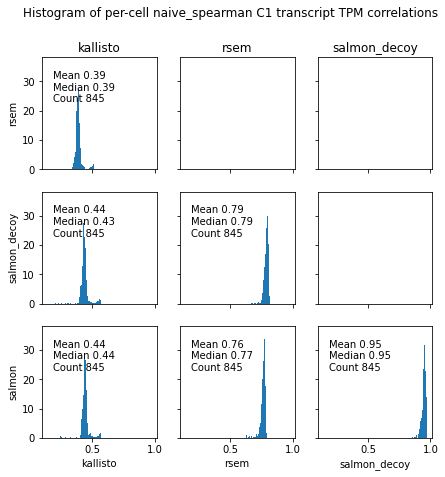

In [90]:
plot_cell_correlation_histogram(c1_transcript_tpm_correlations, 'naive_spearman','Histogram of per-cell {metric} C1 transcript TPM correlations', bins=50)

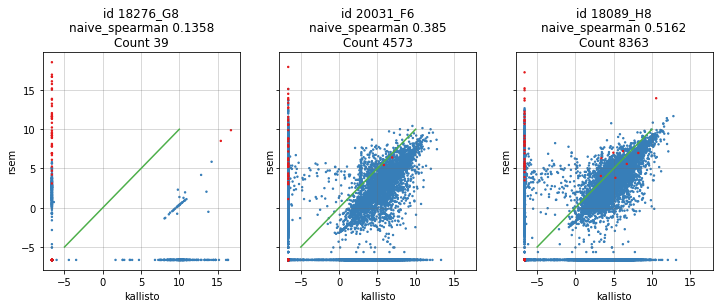

In [91]:
show_scatter_extremes(c1_transcript_tpms, c1_transcript_tpm_correlations, 'naive_spearman', 'kallisto', 'rsem')

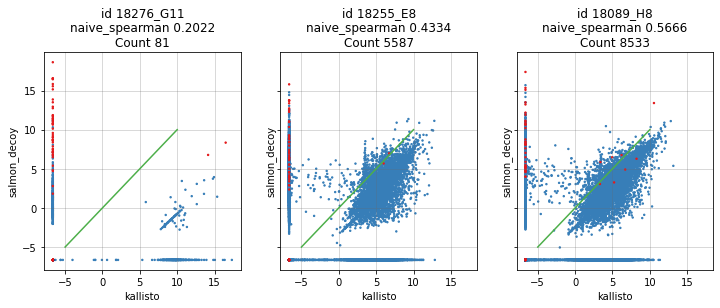

In [92]:
show_scatter_extremes(c1_transcript_tpms, c1_transcript_tpm_correlations, 'naive_spearman', 'kallisto', 'salmon_decoy')

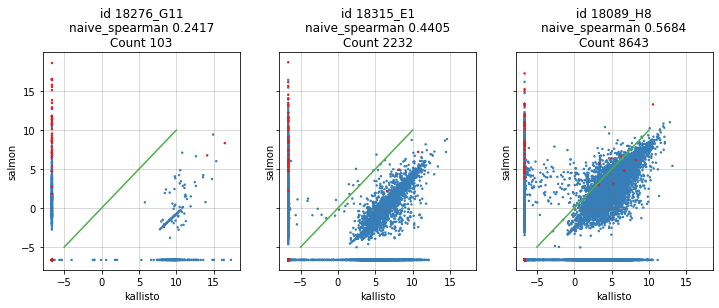

In [93]:
show_scatter_extremes(c1_transcript_tpms, c1_transcript_tpm_correlations, 'naive_spearman', 'kallisto', 'salmon')

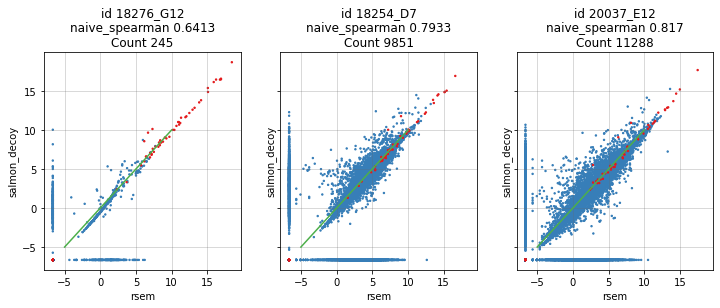

In [94]:
show_scatter_extremes(c1_transcript_tpms, c1_transcript_tpm_correlations, 'naive_spearman', 'rsem', 'salmon_decoy')

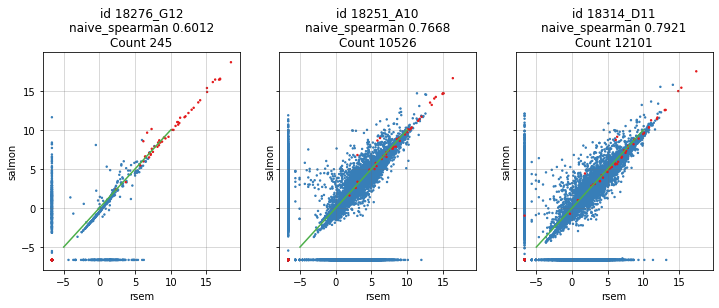

In [95]:
show_scatter_extremes(c1_transcript_tpms, c1_transcript_tpm_correlations, 'naive_spearman', 'rsem', 'salmon')

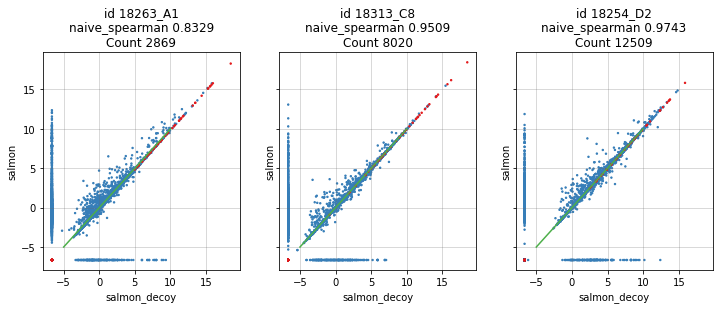

In [96]:
show_scatter_extremes(c1_transcript_tpms, c1_transcript_tpm_correlations, 'naive_spearman', 'salmon_decoy', 'salmon')

# C1 transcript tpm rafa spearman correlation histogram

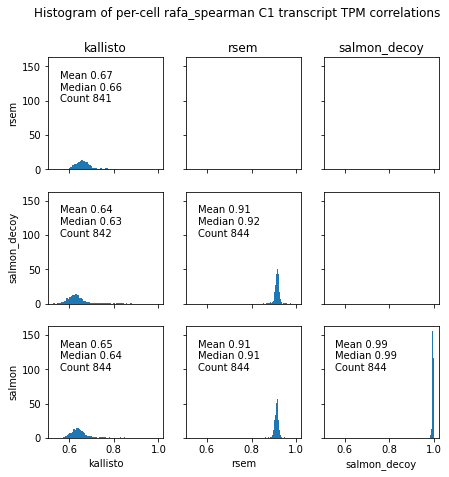

In [97]:
plot_cell_correlation_histogram(c1_transcript_tpm_correlations, 'rafa_spearman','Histogram of per-cell {metric} C1 transcript TPM correlations', bins=50)

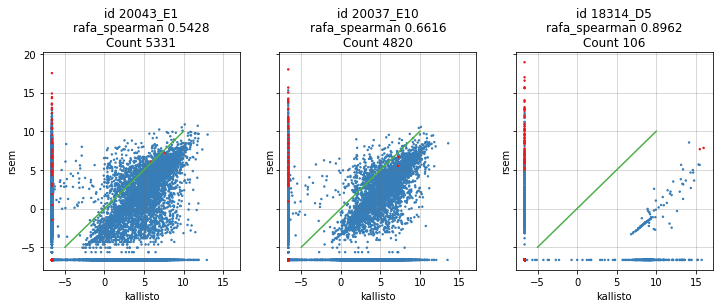

In [98]:
show_scatter_extremes(c1_transcript_tpms, c1_transcript_tpm_correlations, 'rafa_spearman', 'kallisto', 'rsem')

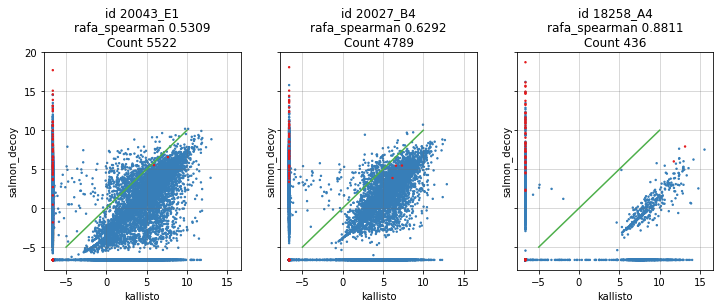

In [99]:
show_scatter_extremes(c1_transcript_tpms, c1_transcript_tpm_correlations, 'rafa_spearman', 'kallisto', 'salmon_decoy')

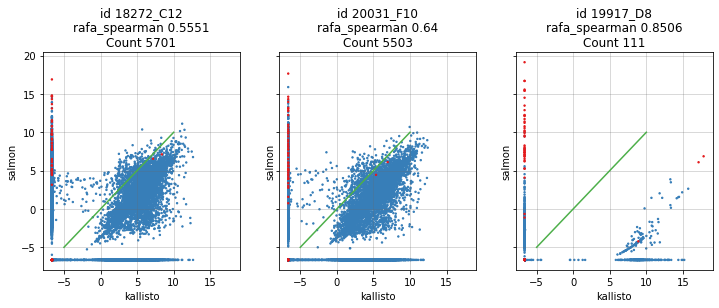

In [100]:
show_scatter_extremes(c1_transcript_tpms, c1_transcript_tpm_correlations, 'rafa_spearman', 'kallisto', 'salmon')

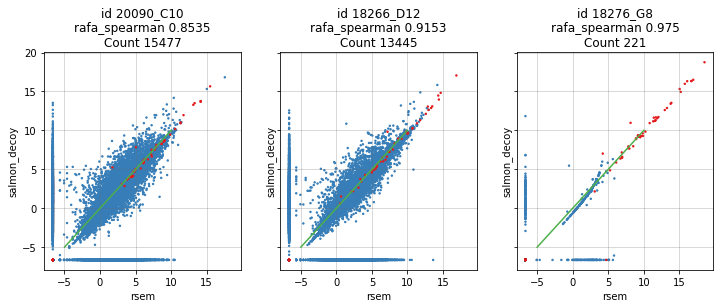

In [101]:
show_scatter_extremes(c1_transcript_tpms, c1_transcript_tpm_correlations, 'rafa_spearman', 'rsem', 'salmon_decoy')

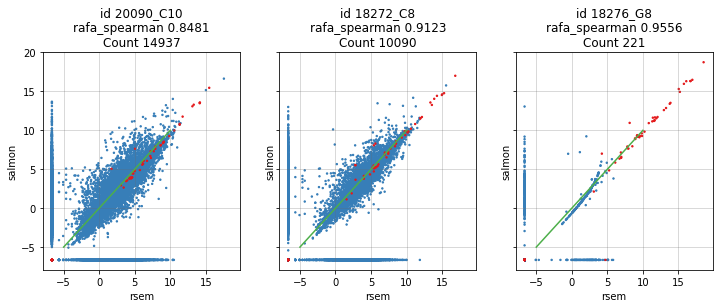

In [102]:
show_scatter_extremes(c1_transcript_tpms, c1_transcript_tpm_correlations, 'rafa_spearman', 'rsem', 'salmon')

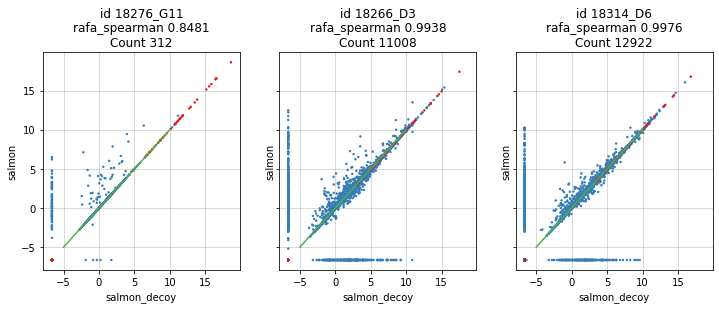

In [103]:
show_scatter_extremes(c1_transcript_tpms, c1_transcript_tpm_correlations, 'rafa_spearman', 'salmon_decoy', 'salmon')